# Classification. Linear models and KNN

In [205]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

In [207]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [208]:
from sklearn.exceptions import NotFittedError

In [209]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
            loss_history: list
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        
        return 1.0/(1.0 + np.exp(-1.0*(X @ weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        #return np.sum(np.log(1. + np.exp(-np.dot(np.dot(weights,x.T),y)))) + 1./(2.* self.C) * np.sum((np.dot(weights,x.T) - y)**2)
        return  1.0 /(x.shape[0]) * sum(np.log((1.0 + np.exp(-1.0*np.sum(y[j] *(x[j] @ weights))))) for j in (range(x.shape[0])))
        #return  np.mean(np.log(1.0 + np.exp(-1.0*np.sum(y*(x @ weights))))) + 1.0/(2.0 * self.C) * np.sqrt(np.sum(weights**2))
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_history = []
        for i in range(self.max_iter):
            #print(sum(y[0] * X_ext[0])*(1.0 - (1.0/(1.0 + np.exp(-1.0*np.sum(y[0]*(X_ext[0] @ self.weights_)))))) )
            delta = self.weights_ / self.C  - (1.0 /(X_ext.shape[0])) * sum(y[j] * X_ext[j]* (1.0 - (1.0/(1.0 + np.exp(-1.0*np.sum(y[j] *(X_ext[j] @ self.weights_)))))) for j in (range(X_ext.shape[0])))
            #delta = self.weights_ / self.C  - ((1.0 /(X_ext.shape[0])) * (y @ X_ext) * (1.0 - (1.0/(1.0 + np.exp(-1.0*np.sum(y*(X_ext @ self.weights_)))))) )#  - 1.  *  np.sum(np.square(self.weights_)) / self.C 
            self.weights_ -= self.eta * delta
            self.loss_history.append(self.get_loss(X_ext,self.weights_,y))
            if (i>self.max_iter) and (np.sqrt(np.sum((self.eta * delta)**2))< self.tol):
                break
        #print(lost_print)
        #plt.plot(lost_print)

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        #return np.round(self.predict_proba(X))
        return np.array([1 if self.predict_proba(X)[i]>0.5 else -1 for i in range(len(X))])

In [210]:
from sklearn import datasets
from sklearn import metrics

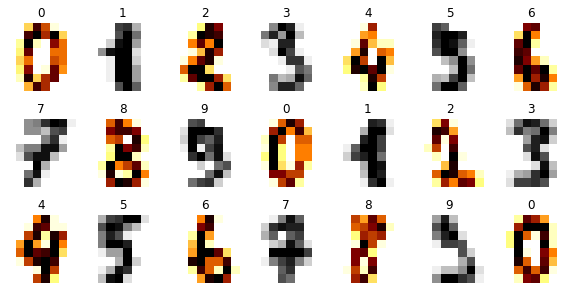

In [211]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [212]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [213]:
from sklearn.metrics import ConfusionMatrixDisplay

In [214]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), \
           metrics.precision_recall_curve(y_true=y_train,probas_pred=clf.predict(X_train)), \
           metrics.precision_recall_curve(y_true=y_test,probas_pred=clf.predict(X_test))      

In [215]:
def fit_evaluate_(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [216]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [217]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [218]:
lr_clf.fit(X_train, y_train)

In [219]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [220]:
model = CustomLogisticRegression()

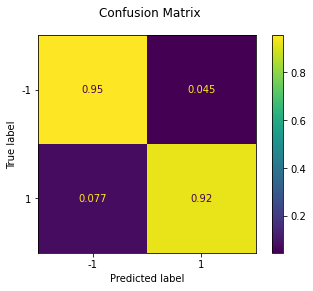

In [221]:
train_acc, test_acc, train_prec, test_prec = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [222]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [223]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

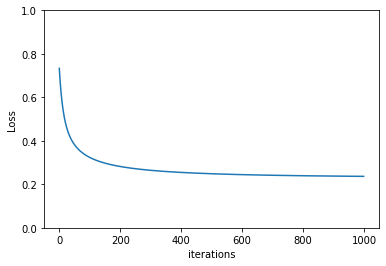

In [224]:
## your code
plt.plot(model.loss_history,)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.ylim(0,1);

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Learning rate: 5


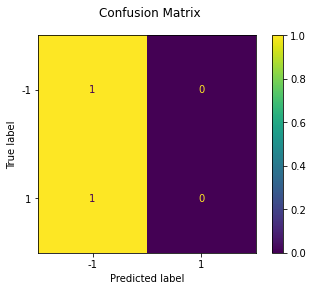

Accuracy_score (train): 49.69%
Accuracy_score (test): 49.17%
**********************************
Learning rate: 0.01


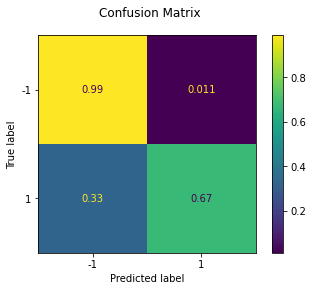

Accuracy_score (train): 83.92%
Accuracy_score (test): 82.78%
**********************************
Learning rate: 0.001


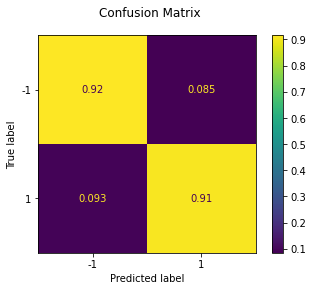

Accuracy_score (train): 88.45%
Accuracy_score (test): 91.11%
**********************************
Learning rate: 1e-07


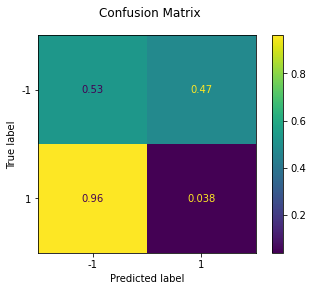

Accuracy_score (train): 28.95%
Accuracy_score (test): 27.78%
**********************************


In [225]:
## your code
losses = []
etas = (5,0.01,0.001,0.0000001)
for i in etas:
    print('Learning rate: ' + str(i))
    model = CustomLogisticRegression(eta=i,max_iter=100)
    train_acc, test_acc, train_dec, test_dec = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')
    losses.append(model.loss_history)


Min-max loss: inf - inf
Min-max loss: 0.3815320474516261 - 3.7647123531633158
Min-max loss: 0.3243026620380246 - 0.7332721252406117
Min-max loss: 0.7601268739696435 - 0.7604115282619344


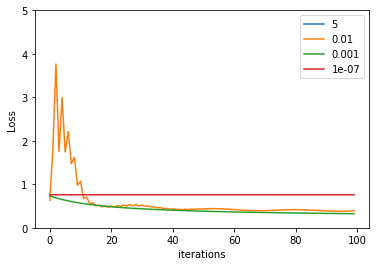

In [226]:
plt.style.context('Solarize_Light2')
x_ = np.arange(100)
plt.ylim(0,5)
plt.xlabel('iterations')
plt.ylabel('Loss')
for i in losses:
    print(f"Min-max loss: {str(np.min(i))} - {str(np.max(i))}")
    plt.plot(x_,i)
    plt.legend(etas)
    
    

Наилучший и стабильный результат при Learning rate = 0.001

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Regularization parameter: 0.5


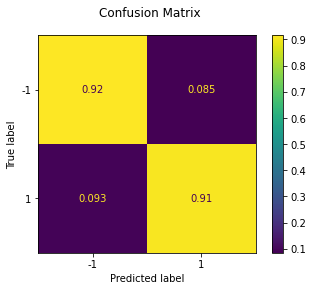

Accuracy_score (train): 88.17%
Accuracy_score (test): 91.11%
**********************************
Regularization parameter: 50


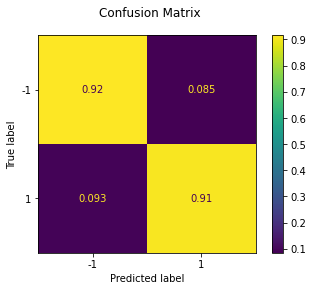

Accuracy_score (train): 88.66%
Accuracy_score (test): 91.11%
**********************************
Regularization parameter: 100


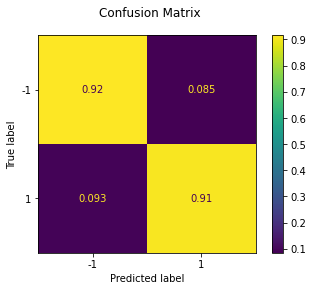

Accuracy_score (train): 88.66%
Accuracy_score (test): 91.11%
**********************************


In [227]:
## your code
C = (0.5,50,100)
for i in C:
    print('Regularization parameter: ' + str(i))
    model = CustomLogisticRegression(C=i,max_iter=100)
    train_acc, test_acc, train_dec, test_dec = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')
    


При сильном увеличении Regularization parameter модель уже не улучшает свои параметры

**(0.5 points)** Compare zero initialization and random initialization. 

zero initialization: False


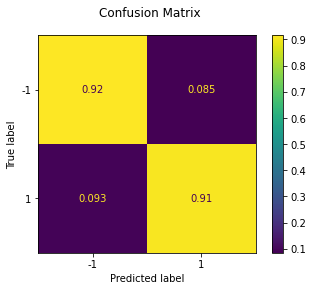

Accuracy_score (train): 88.45%
Accuracy_score (test): 91.11%
**********************************
zero initialization: True


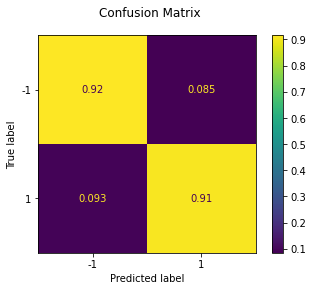

Accuracy_score (train): 88.1%
Accuracy_score (test): 91.11%
**********************************


In [228]:
## your code
losses = []
print('zero initialization: False')
model = CustomLogisticRegression(max_iter=100)
train_acc, test_acc, train_dec, test_dec = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
print('**********************************')
losses.append(model.loss_history)
print('zero initialization: True')
model = CustomLogisticRegression(zero_init=True, max_iter=100)
train_acc, test_acc, train_dec, test_dec = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
print('**********************************')
losses.append(model.loss_history)

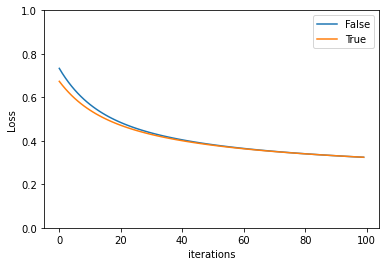

In [230]:
plt.style.context('Solarize_Light2')
x_ = np.arange(100)
plt.ylim(0,1)
plt.xlabel('iterations')
plt.ylabel('Loss')
for i in losses:
    plt.plot(x_,i)
    plt.legend(('False','True'))

Использование значений начальных весов модели не влияет на ее сходимость, это можно заметить на графике Loss

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [231]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        #print(np.linalg.norm(X - Y, axis=1))
        #return np.linalg.norm(X - Y, axis=1)
        
        n_x, n_y = X.shape[0], Y.shape[0]

        D = np.zeros((n_x, n_y), dtype='float')
        for i in range(n_x):
            start = 0
            if X is Y:
                start = i
            for j in range(start, n_y):

                D[i][j] = np.sqrt(sum((X[i][k]-Y[j][k])**2 for k in range(X.shape[1])))
                if X is Y:
                    D[j][i] = D[i][j]
        return D

    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.zeros(len(self.classes_), dtype='float')
        wide_y = {'y':y, 'weigths' : weights}
        df = pd.DataFrame(wide_y)
        df['w_counts'] = df.groupby('y')['weigths'].transform('sum')

        for i in range(len(self.classes_)):

            p[i] = df[df['y'] == self.classes_[i]].iloc[0].w_counts


        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        classes_ = self.classes_
        if hasattr(self, 'points'):
            print(self.y[:, 5])
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1. / (P + self.eps)
            n_queries = len(X)
            all_rows = np.arange(n_queries)   
            sl = np.zeros((self.k))
            probabilities = []
            for k, classes_k in enumerate(classes_):
                pred_labels = self.y[:, k][self.n_neighbors]
                proba_k = np.zeros((n_queries, classes_k.size))

                # a simple ':' index doesn't work right
                for i, idx in enumerate(pred_labels.T):  # loop is O(n_neighbors)
                    proba_k[all_rows, idx] += weights_of_points[:, i]

                # normalize 'votes' into real [0,1] probabilities
                normalizer = proba_k.sum(axis=1)[:, np.newaxis]
                normalizer[normalizer == 0.0] = 1.0
                proba_k /= normalizer

                probabilities.append(proba_k)

            pass# вообщем не случилось....
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [232]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [233]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [234]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

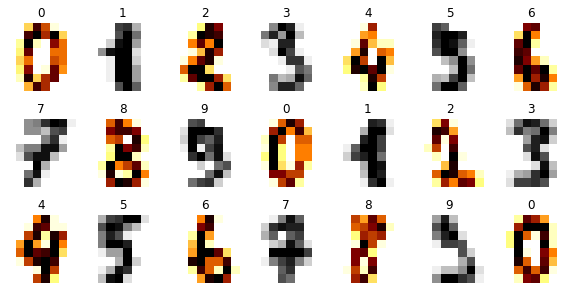

In [235]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

IndexError: index 64 is out of bounds for axis 0 with size 64

In [ ]:
train_acc, test_acc = fit_evaluate_(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

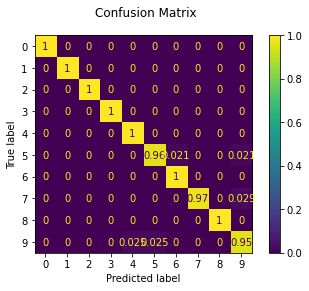

In [236]:
train_acc, test_acc = fit_evaluate_(knn, X_train, y_train, X_test, y_test)

In [237]:
train_acc, test_acc 

(1.0, 0.9861111111111112)

Модель не очень хорошо посчитала номера 5, 9, 7

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

n_neighbors parameter: 5


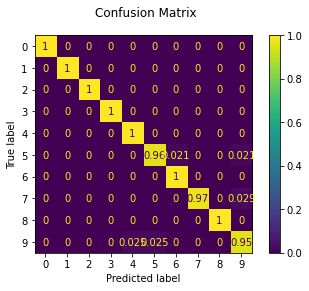

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************
n_neighbors parameter: 1


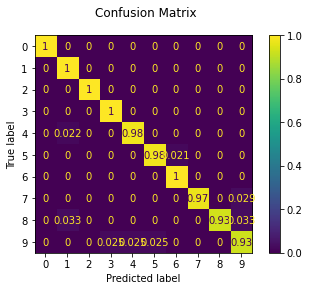

Accuracy_score (train): 100.0%
Accuracy_score (test): 97.78%
**********************************
n_neighbors parameter: 10


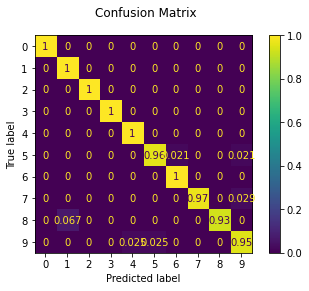

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.06%
**********************************


In [238]:
## your code
n_neighbors = [5,1,10]

for i in n_neighbors:
    print('n_neighbors parameter: ' + str(i))
    model = KNeighborsClassifier(n_neighbors=i, weights='distance')
    train_acc, test_acc= fit_evaluate_(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')
    

Наиболее оптимальное решение при n_neighbors = 5

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

weights parameter: uniform


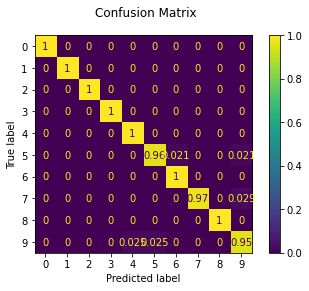

Accuracy_score (train): 98.96%
Accuracy_score (test): 98.61%
**********************************
weights parameter: distance


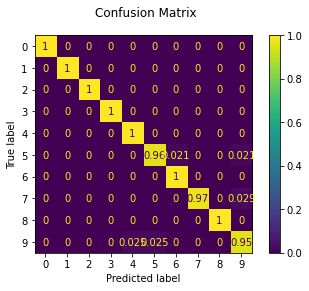

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************


In [182]:
## your code
weights = ['uniform','distance']

for i in weights:
    print('weights parameter: ' + str(i))
    model = KNeighborsClassifier(n_neighbors=5, weights=i)
    train_acc, test_acc= fit_evaluate_(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')
    

Использование 'uniform' и 'distance' показало что на тренировочных данных Accuracy_score больше для 'distance', но на тестовых данных этот параметр одинаков

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

ball_tree


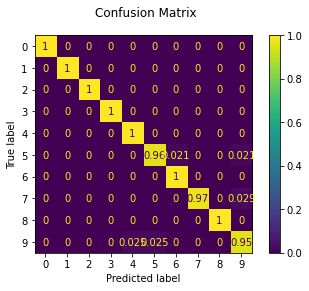

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************
kd_tree


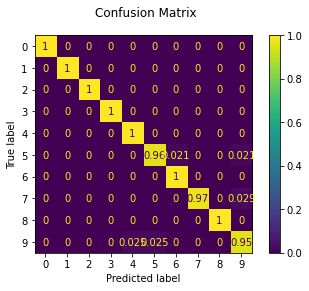

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************
brute


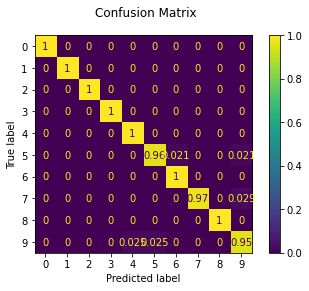

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************


In [186]:
alg = ['ball_tree', 'kd_tree','brute']
for i in alg:
    print(i)
    model = KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm=i)
    train_acc, test_acc= fit_evaluate_(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')

Опытным путем было определено что на предствленных данных изменение алгоритма не влияет на результат

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

manhattan


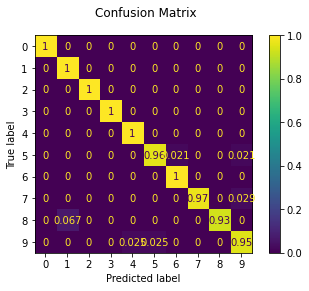

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.06%
**********************************
chebyshev


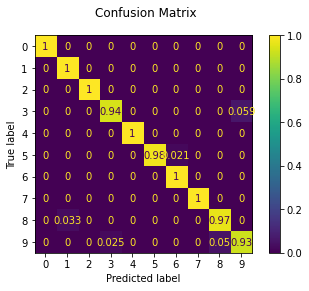

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.06%
**********************************
euclidean


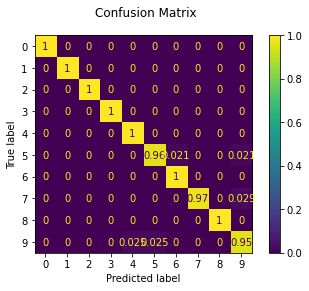

Accuracy_score (train): 100.0%
Accuracy_score (test): 98.61%
**********************************


In [189]:
alg = ['manhattan', 'chebyshev','euclidean']
for i in alg:
    print(i)
    model = KNeighborsClassifier(n_neighbors=5, weights='distance',metric=i)
    train_acc, test_acc= fit_evaluate_(model, X_train, y_train, X_test, y_test)
    print(f"Accuracy_score (train): {str(np.round(train_acc * 100,2))}%")
    print(f"Accuracy_score (test): {str(np.round(test_acc *  100,2))}%")
    print('**********************************')

Расчет расстояния по euclidean метрике дал лучший результат чем остальные

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [239]:
PATH = "./data/"

In [240]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
X_test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [241]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [242]:
## your code
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [243]:
data.shape

(100000, 11)

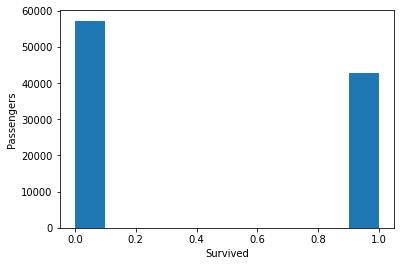

% survived 42.77
% deceased 57.23


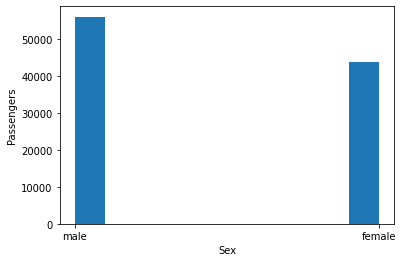

% male 56.11
% female 43.89


In [244]:
data_columns = ['Survived','Sex']

for i in data_columns:
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(i)
    ax.set_ylabel('Passengers')

    plt.hist(data[i])
    plt.show()
    if i == 'Sex':
        print(f"% male {round(data[data['Sex']== 'male'].shape[0] / data.shape[0] * 100,2)}")
        print(f"% female {round(data[data['Sex']== 'female'].shape[0] / data.shape[0] * 100,2)}")
    if i == 'Survived':
        print(f"% survived {round(data[data['Survived']== 1].shape[0] / data.shape[0] * 100,2)}")
        print(f"% deceased {round(data[data['Survived']== 0].shape[0] / data.shape[0] * 100,2)}")


In [11]:

data['Gender'] = data.loc[data['Sex']=='male','Sex']
data['Gender'] = data['Gender'].replace(to_replace=np.NaN,value=1)
data['Gender'] = data['Gender'].replace(to_replace='male',value=0)


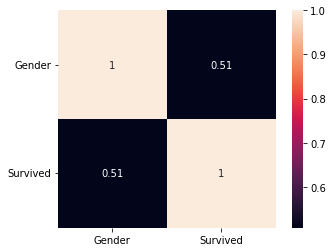

In [13]:

data[['Gender','Survived']].corr()
corr = data[['Gender','Survived']].corr()
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.show()

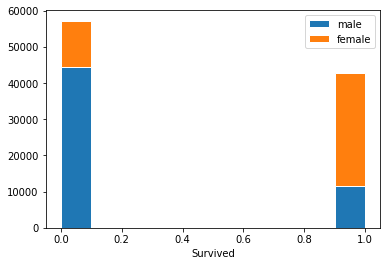

In [14]:

names = ['deceased', 'survived']
b, bins, patches = plt.hist(
    [data.loc[data['Sex'] == 'male', 'Survived'],
     data.loc[data['Sex'] == 'female', 'Survived']],
    stacked=True,
    label=['male', 'female'],
    edgecolor='white')
plt.xlabel('Survived')
plt.legend()

Согласно представленным синтетическим данным на "Титанике" погибло больше мужчин чем женщин, и вообщем было больше погибших чем выживших. Среди погибших больше мужчин чем женщин, соответственно среди выживших больше женщин.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

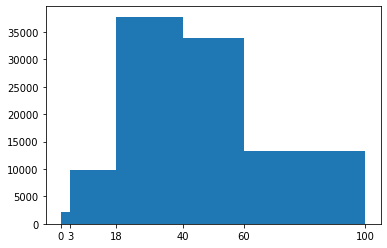

In [15]:
dataAge = data['Age']
bins = [0,3,18,40,60,100]
fig,ax = plt.subplots(1,1)
ax.hist(dataAge, bins = bins)
#ax.ylabel('Passangers')
#ax.xlabel('Age')
ax.set_xticks(bins)

plt.show()

In [16]:
print(f"Survived age average :{round(data[data['Survived'] == 1]['Age'].mean(),4)} median: {round(data[data['Survived'] == 1]['Age'].median(),4)}")
print(f"Deceased age average :{round(data[data['Survived'] == 0]['Age'].mean(),4)} median: {round(data[data['Survived'] == 0]['Age'].median(),4)}")

Survived age average :40.5538 median: 43.0
Deceased age average :36.7087 median: 36.0


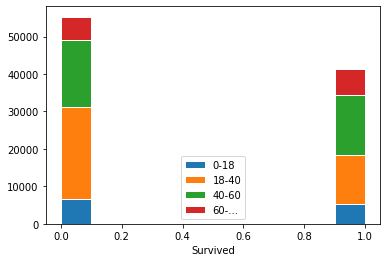

In [17]:
## your code
names = ['deceased', 'survived']
b, bins, patches = plt.hist(
    [data.loc[data['Age']<18, 'Survived'],
     data.loc[(data['Age']>=18) & (data['Age']<40),'Survived'],
     data.loc[(data['Age']>=40) & (data['Age']<60),'Survived'],
     data.loc[data['Age']>=60,'Survived']],
    stacked=True,
    label=['0-18','18-40','40-60','60-...'],
    edgecolor='white')
plt.xlabel('Survived')
plt.legend()


Если судить по представленному выше графику распределение выживших и погибших практически одинаково для всех интервалов возврастов кроме интервала 18-40 лет, это связано с тем что в первую очередь на лодки садили женщин и детей а также состоятельных пассажиров в возрасте... 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

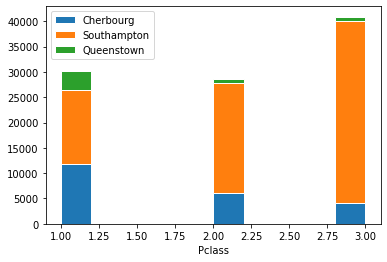

In [18]:
## your code
names = ['deceased', 'survived']
b, bins, patches = plt.hist(
    [data.loc[data['Embarked'] == 'C', 'Pclass'],
    data.loc[data['Embarked'] == 'S', 'Pclass'],
     data.loc[data['Embarked'] == 'Q', 'Pclass']],
    stacked=True,
    label=['Cherbourg', 'Southampton', 'Queenstown'],
    edgecolor='white')
plt.xlabel('Pclass')
plt.legend()

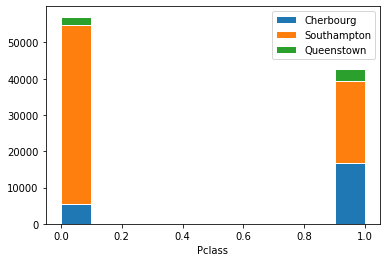

In [19]:
## your code
names = ['deceased', 'survived']
b, bins, patches = plt.hist(
    [data.loc[data['Embarked'] == 'C', 'Survived'],
    data.loc[data['Embarked'] == 'S', 'Survived'],
     data.loc[data['Embarked'] == 'Q', 'Survived']],
    stacked=True,
    label=['Cherbourg', 'Southampton', 'Queenstown'],
    edgecolor='white')
plt.xlabel('Pclass')
plt.legend()

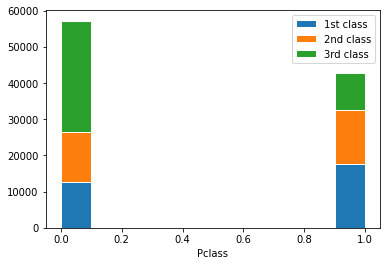

In [20]:
## your code
names = ['deceased', 'survived']
b, bins, patches = plt.hist(
    [data.loc[data['Pclass'] == 1, 'Survived'],
    data.loc[data['Pclass'] == 2, 'Survived'],
     data.loc[data['Pclass'] == 3, 'Survived']],
    stacked=True,
    label=['1st class', '2nd class', '3rd class'],
    edgecolor='white')
plt.xlabel('Pclass')
plt.legend()

Больше всего выжило пассажиров 1-го класса, больше всего погибло пассажиров из 3-го класса с портом посадки Southampton

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [21]:
## your code
data.isnull().mean() * 100
# Calculate the percentage for missing values

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
Gender       0.000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

В колонке "Age" 3,292% пустых данных, заполнение их средними или медианными значениями могут исказить данные, поэтому для исследования лучше будет удалить эти строки.
По поводу колонок "Tiket", "Fare", "Cabin", скорее всего отсутствует информация потому что для пассажиров 3-го класса такая информация не сохранялась.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [22]:
data.dropna(axis = 0, inplace = True)

In [54]:
## your code
from sklearn.linear_model import LogisticRegression

data['Embarked'] = data['Embarked'].replace(to_replace='S',value=0)
data['Embarked'] = data['Embarked'].replace(to_replace='Q',value=1)
data['Embarked'] = data['Embarked'].replace(to_replace='C',value=2)
data['Sex'] = data['Sex'].replace(to_replace='male',value=0)
data['Sex'] = data['Sex'].replace(to_replace='female',value=1)

Column = ['Pclass','Age','SibSp','Parch', 'Embarked','Sex','Embarked','Fare']
X_train, X_test, y_train, y_test = train_test_split(data[Column].to_numpy(), data['Survived'].to_numpy(), test_size=0.2, shuffle=True, random_state=42)

In [24]:
## your code
def make_model(degree, model):    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', model)
    ])

In [25]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

# Logistic regression

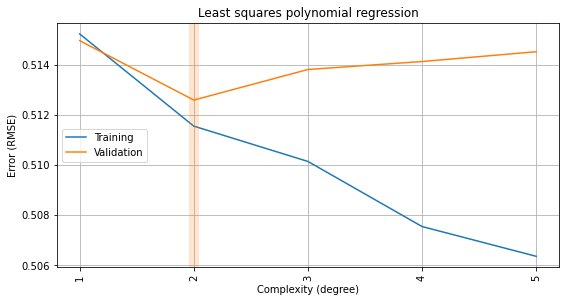

In [55]:
LR = LogisticRegression()

rmse_train, rmse_valid = [], []
DEGREES = [x for x in range(1,6)]
for degree in DEGREES:
    results = cross_validate(make_model(degree,LR), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

In [71]:
mod = make_model(2,LR)


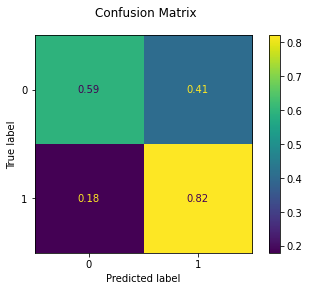

In [72]:
train_acc, test_acc = fit_evaluate_( mod, X_train, y_train, X_test, y_test)

In [73]:
train_acc, test_acc

(0.7386658031088082, 0.7330419297393557)

In [74]:
LR_predict = mod.predict(X_test)

# KNN

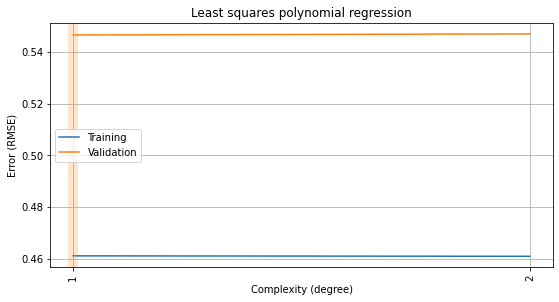

In [66]:
Knn = KNeighborsClassifier()

rmse_train, rmse_valid = [], []
DEGREES = [x for x in range(1,3)]
for degree in DEGREES:
    results = cross_validate(make_model(degree,Knn), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

In [67]:
mod = make_model(1,Knn)

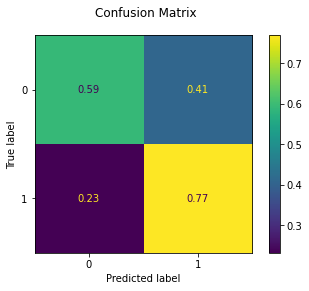

In [68]:
train_acc, test_acc = fit_evaluate_(mod, X_train, y_train, X_test, y_test)

In [69]:
train_acc, test_acc

(0.7880909974093264, 0.6998542982030111)

In [70]:
Knn_predict = mod.predict(X_test)

In [77]:
Knn_predict

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [79]:
np.linalg.norm(Knn_predict - LR_predict)

31.12876483254676

In [87]:
def plot_scatter(x, y, title=None,label='y_true'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

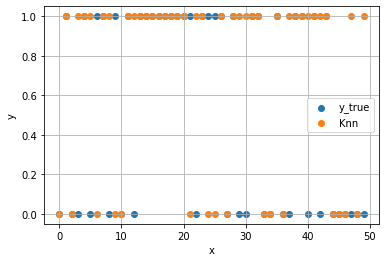

In [91]:
x = np.arange(50)

plot_scatter(x, y_test[:50], label='y_true')
plot_scatter(x, Knn_predict[:50], label='Knn')

plt.legend()

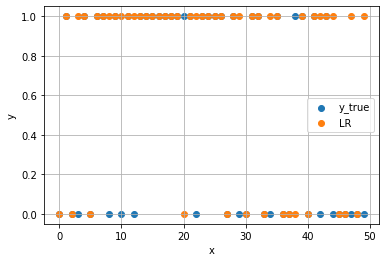

In [89]:
x = np.arange(50)

plot_scatter(x, y_test[:50], label='y_true')

plot_scatter(x, LR_predict[:50], label='LR')
plt.legend()

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

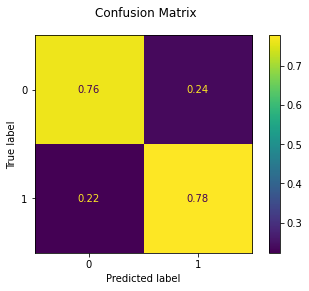

In [259]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
X_test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
LR = LogisticRegression(max_iter=10000, C=0.1)
mod = make_model(2,LR)
#model = KNeighborsClassifier(n_neighbors=5, weights='distance')
#mod = make_model(2,model)
Embarked_mode = data['Embarked'].mode().values[0]
data['Embarked'] = data['Embarked'].replace(to_replace=np.nan,value=Embarked_mode)
data['Embarked'] = data['Embarked'].replace(to_replace='S',value=0)
data['Embarked'] = data['Embarked'].replace(to_replace='Q',value=1)
data['Embarked'] = data['Embarked'].replace(to_replace='C',value=2)
data['Sex'] = data['Sex'].replace(to_replace='male',value=0)
data['Sex'] = data['Sex'].replace(to_replace='female',value=1)
for x in data['Pclass'].unique().tolist():
    Fare_mean = data[data['Pclass']==x]['Fare'].mean()
    data.loc[data['Pclass']==x,'Fare'] = data.loc[data['Pclass']==x,'Fare'].replace(to_replace=np.nan,value=Fare_mean)

    Fare_mean = data[data['Pclass']==x]['Age'].mean()
    data.loc[data['Pclass']==x,'Age'] = data.loc[data['Pclass']==x,'Age'].replace(to_replace=np.nan,value=Fare_mean)

#Column = ['Pclass','Age','SibSp','Parch', 'Embarked','Sex','Embarked','Fare']
Column = ['Pclass','Age','SibSp','Parch', 'Embarked','Sex','Embarked','Fare']
X_train, X_test, y_train, y_test = train_test_split(data[Column].to_numpy(), data['Survived'].to_numpy(), test_size=0.2, shuffle=True, random_state=42)

train_acc, test_acc = fit_evaluate_(mod, X_train, y_train, X_test, y_test)
Embarked_mode = X_test_data['Embarked'].mode().values[0]
X_test_data['Embarked'] = X_test_data['Embarked'].replace(to_replace=np.nan,value=Embarked_mode)
X_test_data['Embarked'] = X_test_data['Embarked'].replace(to_replace='S',value=0)
X_test_data['Embarked'] = X_test_data['Embarked'].replace(to_replace='Q',value=1)
X_test_data['Embarked'] = X_test_data['Embarked'].replace(to_replace='C',value=2)
X_test_data['Sex'] = X_test_data['Sex'].replace(to_replace='male',value=0)
X_test_data['Sex'] = X_test_data['Sex'].replace(to_replace='female',value=1)
for x in X_test_data['Pclass'].unique().tolist():
    Fare_mean = X_test_data[X_test_data['Pclass']==x]['Fare'].mean()
    X_test_data.loc[X_test_data['Pclass']==x,'Fare'] = X_test_data.loc[X_test_data['Pclass']==x,'Fare'].replace(to_replace=np.nan,value=Fare_mean)

for x in X_test_data['Pclass'].unique().tolist():
    Fare_mean = X_test_data[X_test_data['Pclass']==x]['Age'].mean()
    X_test_data.loc[X_test_data['Pclass']==x,'Age'] = X_test_data.loc[X_test_data['Pclass']==x,'Age'].replace(to_replace=np.nan,value=Fare_mean)

#Column = ['Pclass','Age','SibSp','Parch', 'Embarked','Sex','Embarked','Fare']
Column = ['Pclass','Age', 'SibSp','Parch','Embarked','Sex','Embarked','Fare']

df = mod.predict(X_test_data[Column].to_numpy())


In [260]:
train_acc, test_acc

(0.766875, 0.76845)

In [261]:

#df = pd.DataFrame(data=ne.T,columns=['PassengerId','Survived'])
df = pd.DataFrame(data=df,index=np.arange(100000,200000))
#df.set_index('PassengerId')

In [158]:


df

,0
100000,0
100001,1
100002,1
100003,0
100004,1
...,...
199995,1
199996,0
199997,0
199998,1


In [262]:
df.to_csv('out.csv') #PassengerId,Survived

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.